In [106]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model

import japanize_matplotlib

%matplotlib inline

# 乱数seedの固定
np.random.seed(seed=123)

In [107]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec, X):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = lambda_vec[k] *norm.pdf(y)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y, X):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)
    

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        
        #coef_vec[k] = np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    #mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
    mu_vec = np.array([np.mean(X@coef_vec[i]) for i in range(k_size)])
        

    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [160]:
def calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec, X):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの読み込み

Text(0.5, 1.0, '初感染が起きるまでの日数')

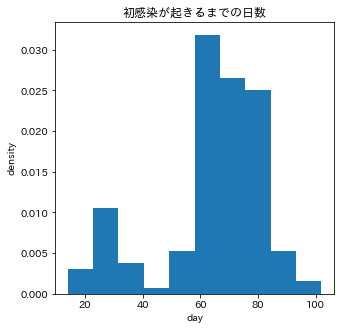

In [161]:
import pandas as pd

# 乱数seedの固定
np.random.seed(seed=123)

df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

y = df["date_first"]
plt.figure(figsize=(5,5))
plt.hist(y, density=True)
plt.xlabel("day")
plt.ylabel("density")
plt.title("初感染が起きるまでの日数")

# Config

In [186]:
FEATS = ["hf", "pop",  "urb", "gdp", "air", "detection"]
k_size=2

### 初期値

In [187]:
sscaler = preprocessing.StandardScaler() # インスタンスの作成

sscaler.fit(df[FEATS])    
X = sscaler.transform(df[FEATS]) # xを変換

if k_size==2:
    y_early = df["date_first"][df["date_first"]<40]
    y_late = df["date_first"][df["date_first"]>40]

    x_early = X[df["date_first"]<40]
    x_late = X[df["date_first"]>40]
    
    clf_early = linear_model.LinearRegression()
    clf_early.fit(x_early, y_early)

    clf_late = linear_model.LinearRegression()
    clf_late.fit(x_late, y_late)
    
    # 早期感染国のβ
    coef1_first=[clf_early.intercept_] + list(clf_early.coef_)
    # 晩期感染国のβ
    coef2_first=[clf_late.intercept_] + list(clf_late.coef_)


    first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=["Intercept"]+ FEATS)
    first_df["晩期感染国β(初期値)"] = coef2_first
    
    X = np.insert(X, 0, 1, axis=1)

    # muの初期値の計算
    # mu = βx
    mu1_first = np.mean(X@coef1_first)
    mu2_first = np.mean(X@coef2_first)

    # sigmaの初期値
    sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
    sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)

    # 混合比率
    lambda_vec=[0.15, 0.85]

    # 説明変数のパラメータ
    mu_vec = [mu1_first, mu2_first]

    # 分散(sigma)の初期値
    sigma2_vec=[sigma1_first, sigma2_first]

    # coefの初期値
    coef_vec = np.array([coef1_first, coef2_first])
else:
    X = np.insert(X, 0, 1, axis=1)
    random_x = np.array_split(y, k_size)
    coef_vec=np.zeros([k_size, len(FEATS)+1])
    mu_vec=np.zeros(k_size)
    sigma2_vec=np.zeros(k_size)
    for i in range(k_size):
        mu_vec[i] = np.mean(random_x[i])
        sigma2_vec[i] = np.sum((random_x[i] - np.mean(y))**2)/random_x[i].shape[0]

    lambda_vec = np.ones(k_size)/k_size


In [188]:
first_df = pd.DataFrame([lambda_vec, mu_vec, sigma2_vec], columns=[f"comp{i}_(初期値)" for i in range(k_size)], index=["混合比", "mu", "sigma"])
first_beta_df = pd.DataFrame(coef_vec.T, columns=[f"comp{i}_(初期値)" for i in range(k_size)],index=["切片"]+FEATS)
first_df = pd.concat([first_df, first_beta_df])
first_df


,comp0_(初期値),comp1_(初期値)
混合比,0.150000,0.850000
mu,27.706694,68.924369
sigma,27.168242,100.769794
切片,27.706694,68.924369
hf,3.847780,-0.651066
pop,0.389038,-9.473606
urb,-0.212951,-3.997060
gdp,-0.160500,-2.824348
air,-0.655912,5.035802
detection,-2.507140,-2.943951


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will

i: 0 lambda [0.1528 0.8472] mu [27.6795 68.9036] sigma2 [ 27.3001 103.545 ]
i: 100 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 200 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 300 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 400 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 500 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 600 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 700 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 800 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 900 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 1000 lambda [0.1527 0.8473] mu [27.672  68.8998] sigma2 [ 27.2842 103.6842]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and w

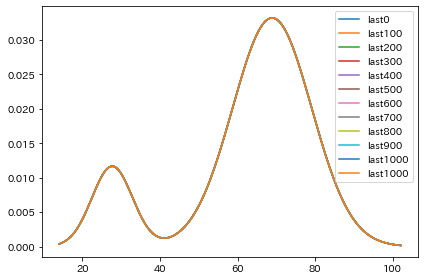

In [189]:
# 1000回繰り返す
x = sp.linspace(np.min(y), np.max(y), len(y))

for i in sp.arange(1000+1):
    # Estep
    # responsibilityの更新 
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec, X)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y, X)
    
    if i % 100 == 0:
        print("i:", i, "lambda", lambda_vec.round(4), "mu", mu_vec.round(4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec, X), label=f"last{i}", linestyle="-")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec, X), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

In [190]:
first_df = pd.DataFrame([lambda_vec, mu_vec, sigma2_vec], columns=[f"comp{i}" for i in range(k_size)], index=["混合比", "mu", "sigma"])
first_beta_df = pd.DataFrame([list(coef_vec[i]) for i in range(k_size)], index=[f"comp{i}" for i in range(k_size)],columns=["切片"]+FEATS).T
first_df = pd.concat([first_df, first_beta_df])
first_df.round(2)

,comp0,comp1
混合比,0.15,0.85
mu,27.67,68.90
sigma,27.28,103.68
切片,27.67,68.90
hf,3.79,-0.64
pop,0.39,-9.31
urb,-0.25,-4.01
gdp,-0.12,-2.81
air,-0.66,4.90
detection,-2.46,-2.97


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


Text(0.5, 1.0, '初感染が起きるまでの日数')

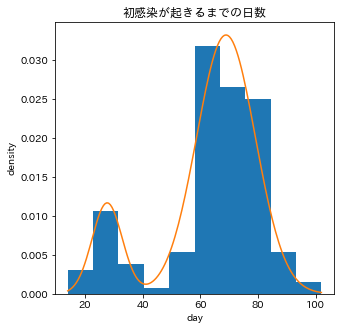

In [191]:
# 推定された分布の可視化
plt.figure(figsize=(5,5))
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec, X), label=f"last{i}", linestyle="-")
plt.xlabel("day")
plt.ylabel("density")
plt.title("初感染が起きるまでの日数")